# Driving on a Mobius Strip

AutomotiveDrivingModels is templated to efficiently run different types of simulations.
Entities are parameterized by their:

- *S* state, which changes over time
- *D* defintion, which does not change over time
- *I* id, typically an `Int`, which uniquely identifies that entity.

In addition to these types, the actions, environment and the driver models can also be parameterized.

This notebook demonstrates a longitudinal driving simulation where cars drive on a single straight lane that loops back on itself.
The types are:

- *S* - `State1D`, containing the position and speed
- *D* - `VehicleDef`, containing length, width, and class
- *I* - `Int`

We use a `StraightRoadway` as our environment and `LaneFollowingDriver`s that produce `LaneFollowingAccel`s.


In [3]:
using AutomotiveDrivingModels
using AutoViz

┌ Info: Precompiling AutoViz [82aa6e0c-a491-5edf-8d4b-c16b98e4ea17]
└ @ Base loading.jl:1273


In [8]:
road_length = 200.0 # [meters]
roadway = StraightRoadway(road_length)

scene = Scene1D()
push!(scene, Entity(State1D(10.0,  8.0), VehicleDef(), 1))
push!(scene, Entity(State1D(50.0, 12.5), VehicleDef(), 2))
push!(scene, Entity(State1D(150.0, 6.0), VehicleDef(), 3))

cam = StaticCamera(position=VecE2(100.0,0.0), zoom=4.75, canvas_height=100)
render([roadway, scene], camera=cam)

MethodError: MethodError: no method matching posg(::State1D)
Closest candidates are:
  posg(!Matched::VehicleState) at C:\Users\Maxime\.julia\dev\AutomotiveDrivingModels\src\states\vehicle_state.jl:29
  posg(!Matched::Frenet, !Matched::Roadway) at C:\Users\Maxime\.julia\dev\AutomotiveDrivingModels\src\roadways\frenet.jl:59
  posg(!Matched::Entity) at C:\Users\Maxime\.julia\dev\AutomotiveDrivingModels\src\states\vehicle_state.jl:35

We can add an overlay that displays the car id for convenience:

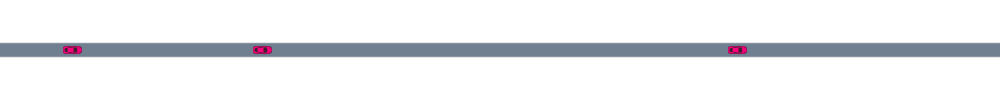

In [3]:
overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true, pos=VecE2(veh.state.s-0.7, 3)) for veh in scene]
render(scene, roadway, overlays, cam=cam, canvas_height=100)

Or we can create a new `SceneOverlay` which does this for us:

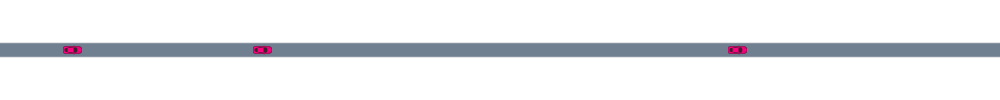

In [4]:
using Parameters
@with_kw struct CarIDOverlay <: SceneOverlay
    textparams::TextParams=TextParams()
end
function AutoViz.render!(rendermodel::RenderModel, overlay::CarIDOverlay, scene::Scene1D, roadway::StraightRoadway)
    for veh in scene
        x = veh.state.s - 0.7
        y = 3.0
        text = string(veh.id)
        add_instruction!(rendermodel, render_text, (text, x, y, overlay.textparams.size, overlay.textparams.color), incameraframe=true)
    end
    return rendermodel
end

render(scene, roadway, [CarIDOverlay()], cam=cam, canvas_height=100)

To run a simulation we need driving models that produce actions.
For this we will use `LaneFollowingDriver`s that produce `LaneFollowingAccel`s.
We will give each car a different model, as a demonstration.

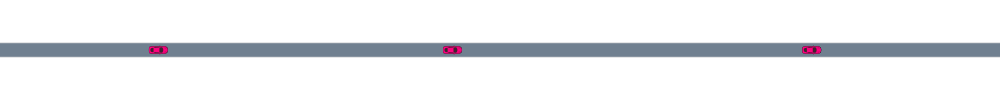

In [5]:
models = Dict{Int, LaneFollowingDriver}()
models[1] = StaticLaneFollowingDriver(0.0) # always produce zero acceleration
models[2] = IntelligentDriverModel(v_des=12.0) # default IDM with a desired speed of 12 m/s
models[3] = PrincetonDriver(v_des = 10.0) # default Princeton driver with a desired speed of 10m/s

nticks = 100
timestep = 0.1
scenes = simulate!(scene, roadway, models, nticks, timestep)
render(last(scenes), roadway, [CarIDOverlay()], cam=cam, canvas_height=100)

We can use Interact to inspect the simulation.

In [7]:
using Interact
@manipulate for step in 1 : length(scenes)
    render(scenes[step], roadway, [CarIDOverlay()], cam=cam, canvas_height=100)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["step"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 101,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
51, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\Maxime\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\Maxime\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\Maxime\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\Maxime\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\Maxime\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000000110f1cd0, Task (runnable) @0x00000000110f1cd0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\"